# Machine Learning in Ocean Remote Sensing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
cb_palette = ['#006BA4', '#FF800E', '#ABABAB']

In [3]:
plt.rcParams.update({'font.size': 16})

## Figure 2

Comparing a simple nonlinear regression, RF, and a NN in deriving chlorophyll from reflectance spectra

We must use baselines to justify complex models

I’m tempted to make a version of this https://m.xkcd.com/2048/ that is specific to some case study here, basically showing some curve fitting with various models and how NNs can overfit.


Grab the NASA NOMAD dataset but with all the headers removed except the column names

In [4]:
df = pd.read_csv('https://seabass.gsfc.nasa.gov/wiki/NOMAD/nomad_seabass_v2.a_2008200.txt', skiprows=list(range(0,88)) + [89,90])
df = df.rename(columns={'/fields=year': 'year'})

print(df.shape)
df.head()

(4459, 217)


,year,month,day,hour,minute,second,lat,lon,id,oisst,...,allo,diato,lut,zea,chl_b,beta-car,alpha-car,alpha-beta-car,flag,cruise
0,2003,4,15,15,15,0,38.4279,-76.61,1565,3.70,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20691,ace0301
1,2003,4,15,16,50,0,38.3680,-76.50,1566,3.70,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20675,ace0301
2,2003,4,15,17,50,0,38.3074,-76.44,1567,3.70,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20691,ace0301
3,2003,4,17,18,15,0,38.6367,-76.32,1568,3.70,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20675,ace0301
4,2003,7,21,18,27,0,38.3047,-76.44,1559,22.03,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20691,ace0302


In [5]:
blue_lw =   'lw443'
blue_es =   'es443'
blue_rrs =  'rrs443'

green_lw =  'lw555'
green_es =  'es555'
green_rrs = 'rrs555'

red_lw =    'lw670'
red_es =    'es670'
red_rrs =   'rrs670'

In [53]:
def chl_fcn(row):
    if row['chl_a'] != -999 :
        return (row['chl_a']) # HPLC
    else:
        return (row['chl']) # flu

df['chl_merge'] = df.apply(lambda row: chl_fcn(row), axis=1)

# whether to use only HPLC or merged chl
# Hu et al 2012 only use HPLC which is chl_a
chl = 'chl_merge' # 'chl_merge'

In [54]:

# make a copy to subset
df_chl = df.copy()

# create the rrs columns
df_chl[blue_rrs] = df_chl[blue_lw]/df_chl[blue_es]
df_chl[green_rrs] = df_chl[green_lw]/df_chl[green_es]
df_chl[red_rrs] = df_chl[red_lw]/df_chl[red_es]

# subset to delete any measurements that are missing
# filter to ensure all the SeaWiFS bands are present
df_chl = df_chl[df_chl['lw443'] != -999]
df_chl = df_chl[df_chl['lw555'] != -999]
df_chl = df_chl[df_chl['lw670'] != -999]
df_chl = df_chl[df_chl['es443'] != -999]
df_chl = df_chl[df_chl['es555'] != -999]
df_chl = df_chl[df_chl['es670'] != -999]
df_chl = df_chl[df_chl['lat'] != -999]
df_chl = df_chl[df_chl['etopo2'] != -999]
df_chl = df_chl[df_chl['lw411'] != -999]
df_chl = df_chl[df_chl['es411'] != -999]
df_chl = df_chl[df_chl['lw489'] != -999]
df_chl = df_chl[df_chl['es489'] != -999]
df_chl = df_chl[df_chl['lw510'] != -999]
df_chl = df_chl[df_chl['es510'] != -999]

df_chl = df_chl[df_chl[chl] != -999]

# subset to only rows that were deeper than 30m
df_chl = df_chl[df_chl['etopo2'] > 30]

# subset to lat between 60N and 60S
df_chl = df_chl[(df_chl['lat'] < 60) & (df_chl['lat'] > -60)]

print("Number of rows remaning after filters: ", len(df_chl))

Number of rows remaning after filters:  487


In [96]:
# don't want any values 0 or below
df_chl = df_chl[np.all(df_chl[[red_es, red_lw, green_lw, blue_lw, chl]] > 0, axis=1)]
print("Number of rows remaning after filters: ", len(df_chl))

Number of rows remaning after filters:  455


Text(0.5, 1.0, 'HPLC chla locations for algorithm development')

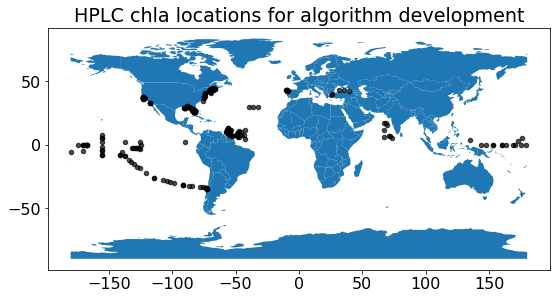

In [97]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(
    df_chl, geometry=gpd.points_from_xy(x=df_chl.lon, y=df_chl.lat)
)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(9,14))
world.plot(ax=ax)
gdf.plot(color='black',markersize=20,alpha=.7,ax=ax)
ax.set_title('HPLC chla locations for algorithm development')
# fig.savefig('locations_alg_dev.png', dpi=300)

In [98]:
X = df_chl[[blue_lw, red_lw,green_lw]].values
y = df_chl[chl].values

# TODO need to add in the stochasticity of the training process

# TODO also maybe log transform the input data for the RF and MLP approaches too

In [173]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=15)

In [174]:
lin_X_train = (X_train[:,0]/X_train[:,1]).reshape(-1,1)
lin_X_train = np.log(lin_X_train)
lin_X_train[np.isinf(lin_X_train)] = 0
lin_X_train[np.isneginf(lin_X_train)] = 0

In [175]:
# Fitting Linear Regression to the dataset 
from sklearn.linear_model import LinearRegression 
lin = LinearRegression() 

lin.fit(lin_X_train, np.log(y_train)) 

LinearRegression()

In [176]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, np.log(y_train))

RandomForestRegressor(random_state=42)

In [177]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(15, 8), random_state=42,max_iter=2000)

mlp.fit(X_train, np.log(y_train))

MLPRegressor(hidden_layer_sizes=(15, 8), max_iter=2000, random_state=42,
             solver='lbfgs')

In [178]:
# ! pip install statsmodels 

In [179]:
import statsmodels.api as sm

## now test out the algorithms

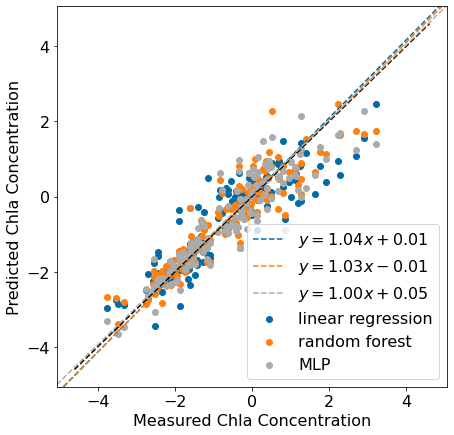

In [181]:
fig, ax = plt.subplots(figsize=(7,7))


####
#### linear regression
####
lin_X_test = (X_test[:,0]/X_test[:,1]).reshape(-1,1)
lin_X_test = np.log(lin_X_test)

lin_preds = lin.predict(lin_X_test)
ax.scatter(np.log(y_test),lin_preds,color=cb_palette[0],label='linear regression')

ols_model = sm.OLS(np.log(y_test),sm.add_constant(lin_preds))
results = ols_model.fit()
# extract intercept b and slope m
b, m = results.params

ax.axline(xy1=(0, b), slope=m, label=f'$y = {m:.2f}x {b:+.2f}$', ls='--',c=cb_palette[0])

####
#### random forest
####

rf_preds = rf.predict(X_test)
ax.scatter(np.log(y_test),rf_preds,color=cb_palette[1],label='random forest')

ols_model = sm.OLS(np.log(y_test),sm.add_constant(rf_preds))
results = ols_model.fit()
# extract intercept b and slope m
b, m = results.params

ax.axline(xy1=(0, b), slope=m, label=f'$y = {m:.2f}x {b:+.2f}$', ls='--',c=cb_palette[1])

####
#### MLP
####

mlp_preds = mlp.predict(X_test)

ax.scatter(np.log(y_test),mlp_preds,color=cb_palette[2],label='MLP')
ax.plot([np.log(10e-3), np.log(100)], [np.log(10e-3), np.log(100)], ls="--",c='k')

ols_model = sm.OLS(np.log(y_test),sm.add_constant(mlp_preds))
results = ols_model.fit()
# extract intercept b and slope m
b, m = results.params

ax.axline(xy1=(0, b), slope=m, label=f'$y = {m:.2f}x {b:+.2f}$', ls='--',c=cb_palette[2])

# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_ylabel('Predicted Chla Concentration')
ax.set_xlabel('Measured Chla Concentration')

ax.legend()

# plt.savefig('figs/multiple_algorithms_for_chla.png',dpi=300)

plt.show()

## how about with a little uncertainty?

In [187]:
mu, sigma = 0, 0.035 # mean and standard deviation
s = np.random.normal(mu, sigma, y_test.shape)+1

(array([ 2.,  0.,  7., 17., 31., 33., 29., 17., 11.,  4.]),
 array([0.88197086, 0.9030632 , 0.92415554, 0.94524788, 0.96634022,
        0.98743257, 1.00852491, 1.02961725, 1.05070959, 1.07180193,
        1.09289427]),
 <BarContainer object of 10 artists>)

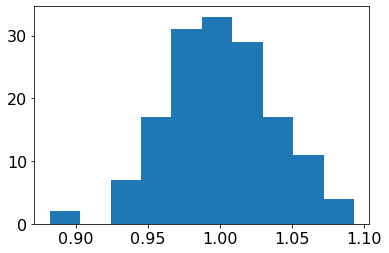

In [188]:
plt.hist(s)

In [ ]:
lin_ms = []
rf_ms = []
mlp_ms = []
for i in range(100):
    # full uncert including training process
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=15)
    
    lin_X_train = (X_train[:,0]/X_train[:,1]).reshape(-1,1)
    lin_X_train = np.log(lin_X_train)
    lin_X_train[np.isinf(lin_X_train)] = 0
    lin_X_train[np.isneginf(lin_X_train)] = 0
    
    lin = LinearRegression() 
    lin.fit(lin_X_train, np.log(y_train)) 
    
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, np.log(y_train))
    
    mlp = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(15, 8), random_state=42,max_iter=2000)
    mlp.fit(X_train, np.log(y_train))
    
    s = np.random.normal(mu, sigma, X_test.shape)+1
    X_test_uncert = X_test*s
    
    s = np.random.normal(mu, sigma, y_test.shape)+1
    y_test = y_test * s
    
    lin_X_test = (X_test_uncert[:,0]/X_test_uncert[:,1]).reshape(-1,1)
    
    lin_X_test = np.log(lin_X_test)

    lin_preds = lin.predict(lin_X_test)
    
    ols_model = sm.OLS(np.log(y_test),sm.add_constant(lin_preds))
    results = ols_model.fit()

    # extract intercept b and slope m
    b, m = results.params
    lin_ms.append(m)
    
    rf_preds = rf.predict(X_test_uncert)
    
    ols_model = sm.OLS(np.log(y_test),sm.add_constant(rf_preds))
    results = ols_model.fit()
    # extract intercept b and slope m
    b, m = results.params
    rf_ms.append(m)
    
    mlp_preds = mlp.predict(X_test_uncert)

    ols_model = sm.OLS(np.log(y_test),sm.add_constant(mlp_preds))
    results = ols_model.fit()
    # extract intercept b and slope m
    b, m = results.params
    
    mlp_ms.append(m)


(array([ 1.,  0.,  1.,  2.,  3.,  7., 15., 30., 29., 12.]),
 array([0.89219129, 0.90239533, 0.91259936, 0.9228034 , 0.93300743,
        0.94321147, 0.95341551, 0.96361954, 0.97382358, 0.98402761,
        0.99423165]),
 <BarContainer object of 10 artists>)

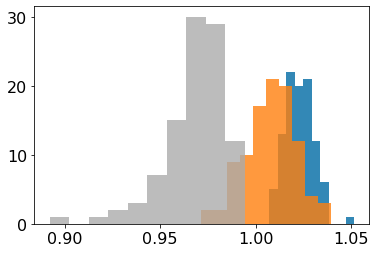

In [190]:
plt.hist(lin_ms,alpha=0.8,color=cb_palette[0])
plt.hist(rf_ms,alpha=0.8,color=cb_palette[1])
plt.hist(mlp_ms,alpha=0.8,color=cb_palette[2])

(array([ 1.,  0.,  1.,  0.,  1.,  5., 12., 37., 33., 10.]),
 array([0.89021848, 0.90198329, 0.9137481 , 0.92551291, 0.93727772,
        0.94904252, 0.96080733, 0.97257214, 0.98433695, 0.99610176,
        1.00786657]),
 <BarContainer object of 10 artists>)

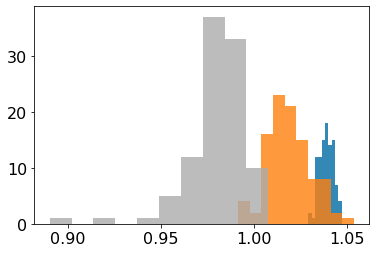

In [185]:
plt.hist(lin_ms,alpha=0.8,color=cb_palette[0])
plt.hist(rf_ms,alpha=0.8,color=cb_palette[1])
plt.hist(mlp_ms,alpha=0.8,color=cb_palette[2])

(array([ 3.,  6.,  9., 15., 13., 23., 18., 10.,  2.,  1.]),
 array([0.82132192, 0.82516445, 0.82900699, 0.83284953, 0.83669206,
        0.8405346 , 0.84437713, 0.84821967, 0.85206221, 0.85590474,
        0.85974728]),
 <BarContainer object of 10 artists>)

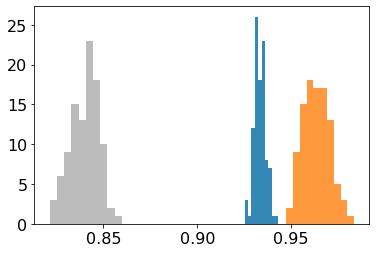

In [172]:
plt.hist(lin_ms,alpha=0.8,color=cb_palette[0])
plt.hist(rf_ms,alpha=0.8,color=cb_palette[1])
plt.hist(mlp_ms,alpha=0.8,color=cb_palette[2])